# Inventory or Workforce Optimization
Choose one scenario and run sensitivity ±10 percent.

In [1]:

from pathlib import Path
import pandas as pd
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, LpStatus, lpSum, LpInteger, LpContinuous, LpBinary, PULP_CBC_CMD

# Example: Workforce planning over 7 days
days = list(range(7))
demand = {d:int(50 + 10*np.sin(d)) for d in days}  # required worker-hours per day
max_hours_per_worker = 8
overtime_cost = 1.5
base_cost = 1.0

prob = LpProblem("WorkforcePlanning", LpMinimize)

# Decision variables: number of workers scheduled each day (integer), overtime hours (continuous)
workers = {d: LpVariable(f"workers_{d}", lowBound=0, cat=LpInteger) for d in days}
ot_hours = {d: LpVariable(f"ot_{d}", lowBound=0, cat=LpContinuous) for d in days}

# Objective: minimize cost
prob += lpSum([base_cost * workers[d] * max_hours_per_worker + overtime_cost * ot_hours[d] for d in days])

# Constraints: cover demand
for d in days:
    prob += workers[d]*max_hours_per_worker + ot_hours[d] >= demand[d]

# Solve
prob.solve(PULP_CBC_CMD(msg=False))
status = LpStatus[prob.status]
print("Status:", status)

sol = pd.DataFrame({
    "day": days,
    "workers": [workers[d].value() for d in days],
    "overtime_hours": [ot_hours[d].value() for d in days],
    "demand": [demand[d] for d in days]
})
sol["base_capacity"] = sol["workers"] * max_hours_per_worker
sol["total_capacity"] = sol["base_capacity"] + sol["overtime_hours"]
print(sol)

# Sensitivity: vary demand ±10 percent and record objective
def run_with_scale(scale):
    demand2 = {d:int(demand[d]*scale) for d in days}
    prob2 = LpProblem("WF_Sensitivity", LpMinimize)
    workers2 = {d: LpVariable(f"w_{d}", lowBound=0, cat=LpInteger) for d in days}
    ot2 = {d: LpVariable(f"ot_{d}", lowBound=0, cat=LpContinuous) for d in days}
    prob2 += lpSum([base_cost * workers2[d]*max_hours_per_worker + overtime_cost*ot2[d] for d in days])
    for d in days:
        prob2 += workers2[d]*max_hours_per_worker + ot2[d] >= demand2[d]
    prob2.solve(PULP_CBC_CMD(msg=False))
    obj = prob2.objective.value()
    return obj

for scale in [0.9, 1.0, 1.1]:
    obj = run_with_scale(scale)
    print(f"Objective at demand scale {scale}: {obj:.2f}")


Status: Optimal
   day  workers  overtime_hours  demand  base_capacity  total_capacity
0    0      6.0             2.0      50           48.0            50.0
1    1      7.0             2.0      58           56.0            58.0
2    2      7.0             3.0      59           56.0            59.0
3    3      6.0             3.0      51           48.0            51.0
4    4      5.0             2.0      42           40.0            42.0
5    5      5.0             0.0      40           40.0            40.0
6    6      6.0             0.0      47           48.0            48.0
Objective at demand scale 0.9: 325.00
Objective at demand scale 1.0: 354.00
Objective at demand scale 1.1: 386.50


In [2]:
# Cell 0 - imports and seed

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pulp import (
    LpProblem, LpMinimize, LpVariable, LpInteger, LpContinuous,
    LpStatus, lpSum, PULP_CBC_CMD
)
np.random.seed(42)
figdir = Path("figures"); figdir.mkdir(exist_ok=True)


In [3]:
# Cell 1 - seven day demand and variables 
# Synthetic weekly demand - you can tweak
days = list(range(7))
demand = {d: int(50 + 12*np.sin(d) + np.random.normal(0, 2)) for d in days}

max_hours_per_worker = 8
base_cost = 1.0       # cost per base hour
overtime_cost = 1.6   # cost per OT hour

# Decision variables
prob = LpProblem("WorkforcePlanning", LpMinimize)
workers = {d: LpVariable(f"workers_{d}", lowBound=0, cat=LpInteger) for d in days}
ot = {d: LpVariable(f"ot_{d}", lowBound=0, cat=LpContinuous) for d in days}

# Objective
prob += lpSum([base_cost*workers[d]*max_hours_per_worker + overtime_cost*ot[d] for d in days])

# Capacity constraints
for d in days:
    prob += workers[d]*max_hours_per_worker + ot[d] >= demand[d]

status = prob.solve(PULP_CBC_CMD(msg=False))
print("Status:", LpStatus[status])


Status: Optimal


In [4]:
# Cell 2 - Solution Table 
sol = pd.DataFrame({
    "day": days,
    "demand_hours": [demand[d] for d in days],
    "workers": [workers[d].value() for d in days],
    "ot_hours": [ot[d].value() for d in days],
})
sol["base_capacity"] = sol["workers"] * max_hours_per_worker
sol["total_capacity"] = sol["base_capacity"] + sol["ot_hours"]
total_cost = (base_cost * sol["base_capacity"]).sum() + (overtime_cost * sol["ot_hours"]).sum()
display(sol)
print(f"Optimal cost at 1.0x demand: {total_cost:.1f}")


,day,demand_hours,workers,ot_hours,base_capacity,total_capacity
0,0,50,6.0,2.0,48.0,50.0
1,1,59,7.0,3.0,56.0,59.0
2,2,62,8.0,0.0,64.0,64.0
3,3,54,7.0,0.0,56.0,56.0
4,4,40,5.0,0.0,40.0,40.0
5,5,38,5.0,0.0,40.0,40.0
6,6,49,6.0,1.0,48.0,49.0


Optimal cost at 1.0x demand: 361.6


Saved chart: figures/day4_sensitivity.png
{'scales': [0.9, 1.0, 1.1, 1.2], 'costs': [328.0, 361.6, 395.2, 428.8]}


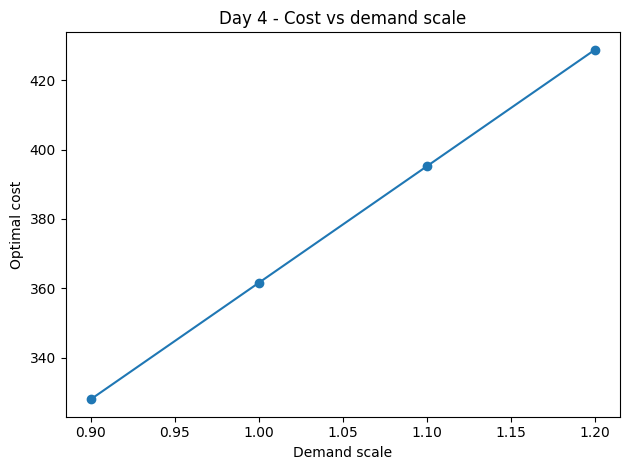

In [5]:
# Cell 3 - sensitivity function and chart
def solve_with_scale(scale: float) -> float:
    demand2 = {d: int(demand[d]*scale) for d in days}
    p = LpProblem("WF_sens", LpMinimize)
    w = {d: LpVariable(f"w_{d}", lowBound=0, cat=LpInteger) for d in days}
    o = {d: LpVariable(f"o_{d}", lowBound=0, cat=LpContinuous) for d in days}
    p += lpSum([base_cost*w[d]*max_hours_per_worker + overtime_cost*o[d] for d in days])
    for d in days:
        p += w[d]*max_hours_per_worker + o[d] >= demand2[d]
    p.solve(PULP_CBC_CMD(msg=False))
    return float(p.objective.value())

scales = [0.9, 1.0, 1.1, 1.2]
objs = [solve_with_scale(s) for s in scales]

plt.figure()
plt.plot(scales, objs, marker="o")
plt.xlabel("Demand scale")
plt.ylabel("Optimal cost")
plt.title("Day 4 - Cost vs demand scale")
plt.tight_layout()
out = figdir / "day4_sensitivity.png"
plt.savefig(out)
print("Saved chart:", out)
print({"scales": scales, "costs": [round(x,1) for x in objs]})


In [6]:
# Cell 4 - So What(business readout) + Save

lines = [
    "Optimal schedule meets demand at minimum cost with controlled overtime.",
    f"Cost rises from {objs[1]:.1f} at 1.0x demand to {objs[-1]:.1f} at 1.2x.",
    "Set an overtime cap per day and cross train to reduce OT spikes.",
    "Next - add headcount ramp limits and minimum-days-on-shift rule."
]
Path("SO_WHAT_DAY4.txt").write_text("So what (Day 4):\n- " + "\n- ".join(lines))
print("\n".join(lines))


Optimal schedule meets demand at minimum cost with controlled overtime.
Cost rises from 361.6 at 1.0x demand to 428.8 at 1.2x.
Set an overtime cap per day and cross train to reduce OT spikes.
Next - add headcount ramp limits and minimum-days-on-shift rule.


In [7]:
# Cell 5 - verification

from pathlib import Path, PurePosixPath
missing = []
if not (figdir / "day4_sensitivity.png").exists():
    missing.append("optimizer/figures/day4_sensitivity.png")
report = {
    "rows_in_solution": len(sol),
    "min_total_capacity_vs_demand": float((sol["total_capacity"] - sol["demand_hours"]).min()),
    "chart_written": len(missing) == 0,
    "missing": missing
}
print(report)


{'rows_in_solution': 7, 'min_total_capacity_vs_demand': 0.0, 'chart_written': True, 'missing': []}
